In [1]:
import pandas as pd
import duckdb as ddb
import numpy as np

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
con = ddb.connect("./kalam_hydropower.db")

## Analysis and Feature Engineering
Now that the data has been aggregated, it is easier to work with in pandas and visualise using matplotlib and seaborn. The inention of this section is to:
- Produce features that are intuitive - i.e. hypothesize on what could support forecasting
- Visualise the feature signals to understand how the data varies with the target signal over time
- Check the feature covariation with the target data (daily kwh) to get a sense of which features to try

We start by examining the high-level features of the daily hydropower production data.

In [3]:
dhp_df = con.sql("""
    select
        *
    from prepared.daily_hydropower_production
""").to_df()

dhp_df.head()

,date,source,consumer_device,data_user,kwh
0,2024-07-22,consumer_device_10_data_user_1,10,1,0.024330
1,2024-07-23,consumer_device_10_data_user_1,10,1,0.103560
2,2024-07-24,consumer_device_10_data_user_1,10,1,0.137543
3,2024-07-25,consumer_device_10_data_user_1,10,1,0.121011
4,2024-07-26,consumer_device_10_data_user_1,10,1,0.000000


In [4]:
dhp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136409 entries, 0 to 136408
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             136409 non-null  datetime64[us]
 1   source           136409 non-null  object        
 2   consumer_device  136409 non-null  object        
 3   data_user        136409 non-null  object        
 4   kwh              136409 non-null  float64       
dtypes: datetime64[us](1), float64(1), object(3)
memory usage: 5.2+ MB


In [5]:
aggregated_dhp_df = dhp_df[["date", "kwh"]].groupby("date", as_index=False).sum()

<Axes: title={'center': 'Daily Power Production'}, xlabel='date'>

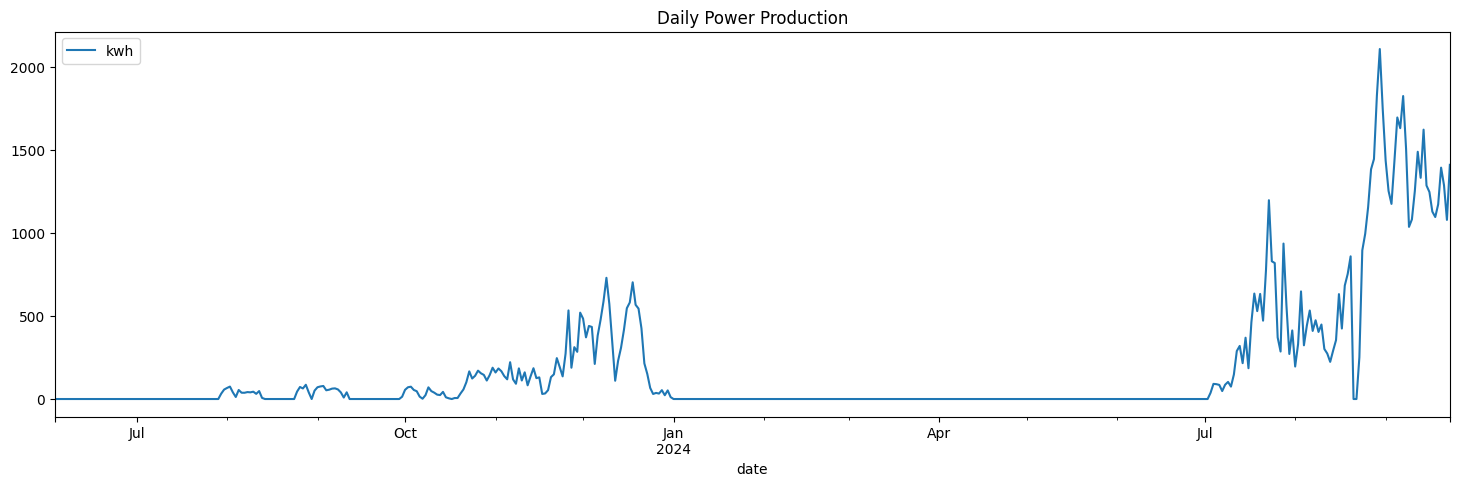

In [6]:
aggregated_dhp_df.plot(x="date", y="kwh", figsize=(18, 5), title="Daily Power Production")

In [7]:
ss_df = con.sql("select * from raw.sample_submission").to_df()

ss_df.head()

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0
1,2024-09-25_consumer_device_12_data_user_1,0
2,2024-09-26_consumer_device_12_data_user_1,0
3,2024-09-27_consumer_device_12_data_user_1,0
4,2024-09-28_consumer_device_12_data_user_1,0


In [8]:
ss_df[["date", "source"]] = ss_df['ID'].str.split('_', n=1, expand=True)

ss_df.head()

,ID,kwh,date,source
0,2024-09-24_consumer_device_12_data_user_1,0,2024-09-24,consumer_device_12_data_user_1
1,2024-09-25_consumer_device_12_data_user_1,0,2024-09-25,consumer_device_12_data_user_1
2,2024-09-26_consumer_device_12_data_user_1,0,2024-09-26,consumer_device_12_data_user_1
3,2024-09-27_consumer_device_12_data_user_1,0,2024-09-27,consumer_device_12_data_user_1
4,2024-09-28_consumer_device_12_data_user_1,0,2024-09-28,consumer_device_12_data_user_1


In [9]:
print(f"Number of unique sources in actual data: {len(dhp_df['source'].unique())}")
print(f"Number of unique sources in submission data: {len(ss_df['source'].unique())}")

Number of unique sources in actual data: 585
Number of unique sources in submission data: 194


In [10]:
# These are devices with weak signals which we can exclude from the analysis - these were mentioned in the samplesubmission notebook
devices_to_drop = ["3", "5", "11", "14", "15", "17", "24", "25", "27", "33", "4", "9"]

In [11]:
to_forecast_df = dhp_df[~(dhp_df["consumer_device"].isin(devices_to_drop))].copy()

In [12]:
to_forecast_df.head()

,date,source,consumer_device,data_user,kwh
0,2024-07-22,consumer_device_10_data_user_1,10,1,0.024330
1,2024-07-23,consumer_device_10_data_user_1,10,1,0.103560
2,2024-07-24,consumer_device_10_data_user_1,10,1,0.137543
3,2024-07-25,consumer_device_10_data_user_1,10,1,0.121011
4,2024-07-26,consumer_device_10_data_user_1,10,1,0.000000


In [13]:
# Pivot the data such that all the different device, user combinations become independent columns at the same length
to_forecast_pivotted_df = to_forecast_df.pivot(columns="source", index="date", values="kwh").copy()

# Not all of the signals have the same length, in this case I simply fill missing/non-existant values with a 0
to_forecast_pivotted_df.fillna(0, inplace=True)

to_forecast_pivotted_df.head()

source,consumer_device_10_data_user_1,consumer_device_10_data_user_10,consumer_device_10_data_user_11,consumer_device_10_data_user_12,consumer_device_10_data_user_13,consumer_device_10_data_user_14,consumer_device_10_data_user_15,consumer_device_10_data_user_16,consumer_device_10_data_user_17,consumer_device_10_data_user_18,...,consumer_device_8_data_user_17,consumer_device_8_data_user_18,consumer_device_8_data_user_2,consumer_device_8_data_user_3,consumer_device_8_data_user_4,consumer_device_8_data_user_5,consumer_device_8_data_user_6,consumer_device_8_data_user_7,consumer_device_8_data_user_8,consumer_device_8_data_user_9
date,,,,,,,,,,,,,,,,,,,,,
2023-06-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Now I melt the dataframe back into a row-based structure, but I am guarenteed that all signals are the same length
to_forecast_extended_df = to_forecast_pivotted_df.melt(value_vars=list(to_forecast_pivotted_df.columns), var_name="source", value_name="kwh", ignore_index=False)

to_forecast_extended_df.reset_index(inplace=True, drop=False)

to_forecast_extended_df.head()

,date,source,kwh
0,2023-06-24,consumer_device_10_data_user_1,0.0
1,2023-06-25,consumer_device_10_data_user_1,0.0
2,2023-06-26,consumer_device_10_data_user_1,0.0
3,2023-06-27,consumer_device_10_data_user_1,0.0
4,2023-06-28,consumer_device_10_data_user_1,0.0


In [15]:
# I create a dataframe with the sum of kwh across all user/device combinations for easy visualisation (i.e. one series instead of over 400)
power_df = to_forecast_extended_df[["date", "kwh"]].groupby("date", as_index=False).sum()

power_df.head()

,date,kwh
0,2023-06-24,0.001223
1,2023-06-25,0.000000
2,2023-06-26,0.000000
3,2023-06-27,0.000000
4,2023-06-28,0.000000


In [16]:
# Now I pull the daily climate data into a dataframe for feature engineering
climate_df = con.sql("select * from prepared.daily_climate").to_df()

climate_df.head()

,date,avg_temperature,avg_dewpoint_temperature,avg_u_wind_component,avg_v_wind_component,total_precipitation,total_snowfall,avg_snow_cover_perc
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008650,0.000000e+00,99.972656


In [17]:
# Features taken from an example notebook - these seem intuitive as power production likely depends on rainfall and temperature (melting of snow)
climate_df["temp_dew_diff"] = climate_df["avg_temperature"] - climate_df["avg_dewpoint_temperature"]
climate_df["wind_speed"] = (climate_df["avg_u_wind_component"]**2 + climate_df["avg_v_wind_component"]**2)**0.5
climate_df["precip_snow_ratio"] = climate_df["total_precipitation"] / (climate_df["total_snowfall"] + 1e-6)
climate_df["precip_minus_snow"] = climate_df["total_precipitation"] - climate_df["total_snowfall"]

# Some more 'out there' features to try - these were basically some brainstorm features I thought might work
climate_df["rolling_precip_7d"] = climate_df["total_precipitation"].rolling(7).sum()
climate_df["rolling_snow_30d"] = climate_df["total_snowfall"].rolling(30).sum()
climate_df["melt_potential"] = climate_df["avg_temperature"] * climate_df["avg_snow_cover_perc"]
climate_df["wind_variability_3d"] = climate_df["wind_speed"].rolling(3).std()

In [18]:
# Temporal features - features based on time/seasonality
climate_df["dayofyear"] = climate_df["date"].dt.dayofyear
climate_df["month"] = climate_df["date"].dt.month
climate_df["sin_doy"] = np.sin(2 * np.pi * climate_df["dayofyear"] / 365)
climate_df["cos_doy"] = np.cos(2 * np.pi * climate_df["dayofyear"] / 365)

In [19]:
all_data_df = pd.merge(climate_df, power_df, on="date", how="left")

all_data_df.head()

,date,avg_temperature,avg_dewpoint_temperature,avg_u_wind_component,avg_v_wind_component,total_precipitation,total_snowfall,avg_snow_cover_perc,temp_dew_diff,wind_speed,...,precip_minus_snow,rolling_precip_7d,rolling_snow_30d,melt_potential,wind_variability_3d,dayofyear,month,sin_doy,cos_doy,kwh
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656,5.208944,0.658203,...,0.004557,NaN,NaN,185.977159,NaN,154,6,0.471160,-0.882048,NaN
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656,5.897942,0.536706,...,0.024096,NaN,NaN,399.164785,NaN,155,6,0.455907,-0.890028,NaN
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656,8.576181,0.518888,...,0.011578,NaN,NaN,479.321249,0.075815,156,6,0.440519,-0.897743,NaN
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656,10.975005,0.478963,...,0.008914,NaN,NaN,630.266635,0.029568,157,6,0.425000,-0.905193,NaN
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008650,0.000000e+00,99.972656,10.969686,0.523335,...,0.008650,NaN,NaN,700.200726,0.024435,158,6,0.409356,-0.912375,NaN


In [20]:
# The features and the target data are all on different scales, and I want to observe the shape of the signals,
# so for this I produce a scaled set of data to visualise
scaler = StandardScaler()

numeric_columns = all_data_df.select_dtypes("number").columns

scaled_data_df = all_data_df.copy()
scaled_data_df[numeric_columns] = scaler.fit_transform(all_data_df[numeric_columns])

In [21]:
# Here I define the feature columns I want to plot against kwh
feature_columns = list(all_data_df.columns)

feature_columns.remove("date")
feature_columns.remove("kwh")

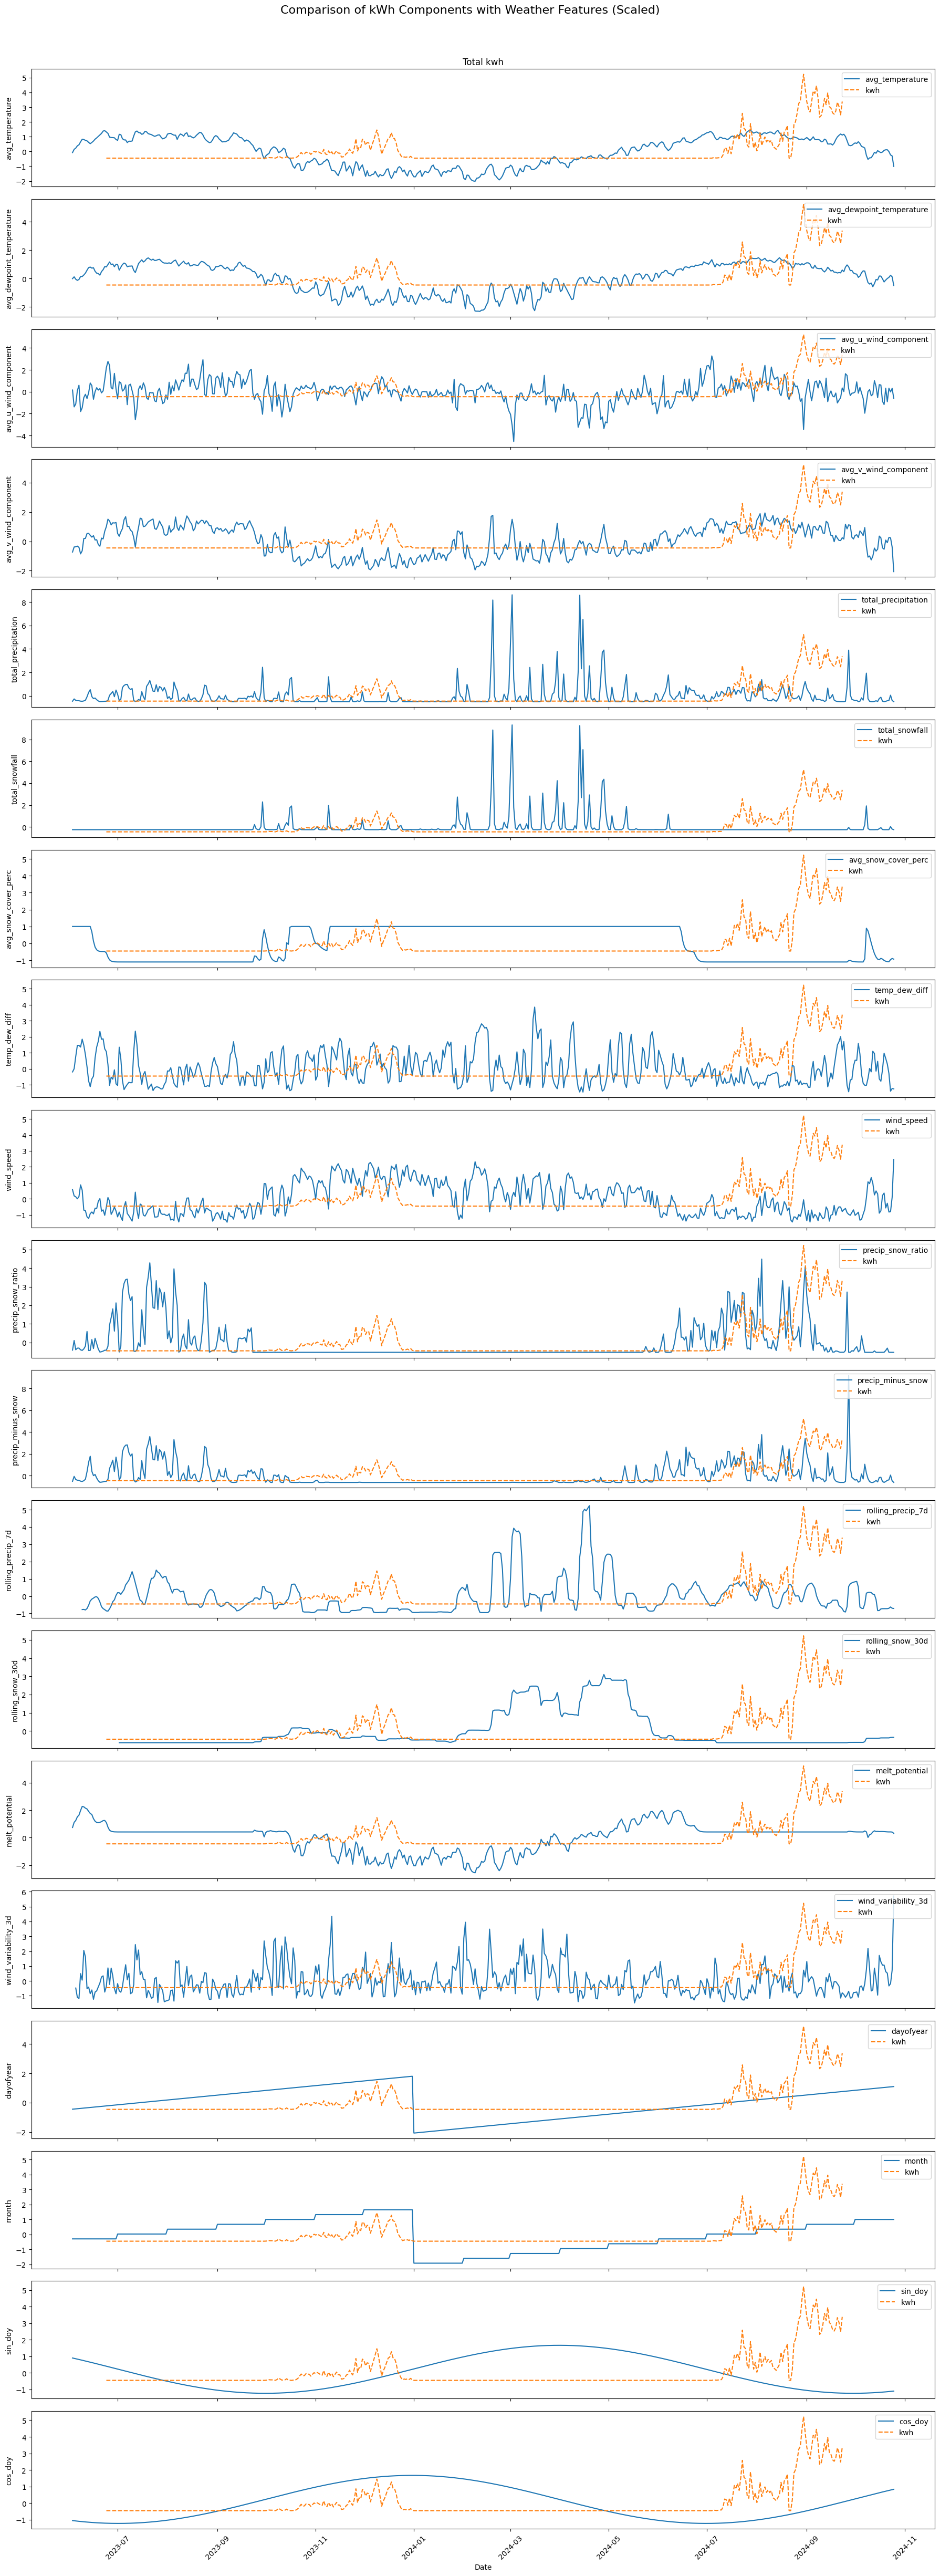

In [22]:
# Define the kWh components and feature components
kwh_components = ['kwh']
features = feature_columns

# Create subplots: one row per feature
fig, axes = plt.subplots(len(features), len(kwh_components), figsize=(18, 50), sharex=True)
fig.suptitle('Comparison of kWh Components with Weather Features (Scaled)', fontsize=16)

for i, feature in enumerate(features):
    ax = axes[i]
    ax.plot(scaled_data_df['date'], scaled_data_df[feature], label=feature)
    ax.plot(scaled_data_df['date'], scaled_data_df["kwh"], label="kwh", linestyle='--')
    ax.set_ylabel(feature)
    if i == len(features) - 1:
        ax.set_xlabel('Date')
    if i == 0:
        ax.set_title("Total kwh")
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

What is clear from these sub-plots is the following:
- There is a significant 'downtime' period from 2024-01 to 2024-07, no power is being produced between those times
- Precipitation minus snow (only rainfall) coincides with power production
- Snowfall does not seem to have an impact in 2024 - i.e. high snowfall does not imply high power production
- Temperature rises in 2024 seem to coincide with power production
- There is clearly a seasonality in power production, and temporal features reflect that, sin_doy, dayofyear and month seem to be good candidates to reflect this

Now, given that this is a time series problem it may not be that the date-aligned features at some lag may be better predictors. I want to understand correlation over various lags of the features.

In [25]:
# Ensure that the data is ordered appropriately for the correlation check
all_data_df.sort_values(by="date", inplace=True)
all_data_df.head()

,date,avg_temperature,avg_dewpoint_temperature,avg_u_wind_component,avg_v_wind_component,total_precipitation,total_snowfall,avg_snow_cover_perc,temp_dew_diff,wind_speed,...,precip_minus_snow,rolling_precip_7d,rolling_snow_30d,melt_potential,wind_variability_3d,dayofyear,month,sin_doy,cos_doy,kwh
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656,5.208944,0.658203,...,0.004557,NaN,NaN,185.977159,NaN,154,6,0.471160,-0.882048,NaN
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656,5.897942,0.536706,...,0.024096,NaN,NaN,399.164785,NaN,155,6,0.455907,-0.890028,NaN
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656,8.576181,0.518888,...,0.011578,NaN,NaN,479.321249,0.075815,156,6,0.440519,-0.897743,NaN
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656,10.975005,0.478963,...,0.008914,NaN,NaN,630.266635,0.029568,157,6,0.425000,-0.905193,NaN
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008650,0.000000e+00,99.972656,10.969686,0.523335,...,0.008650,NaN,NaN,700.200726,0.024435,158,6,0.409356,-0.912375,NaN


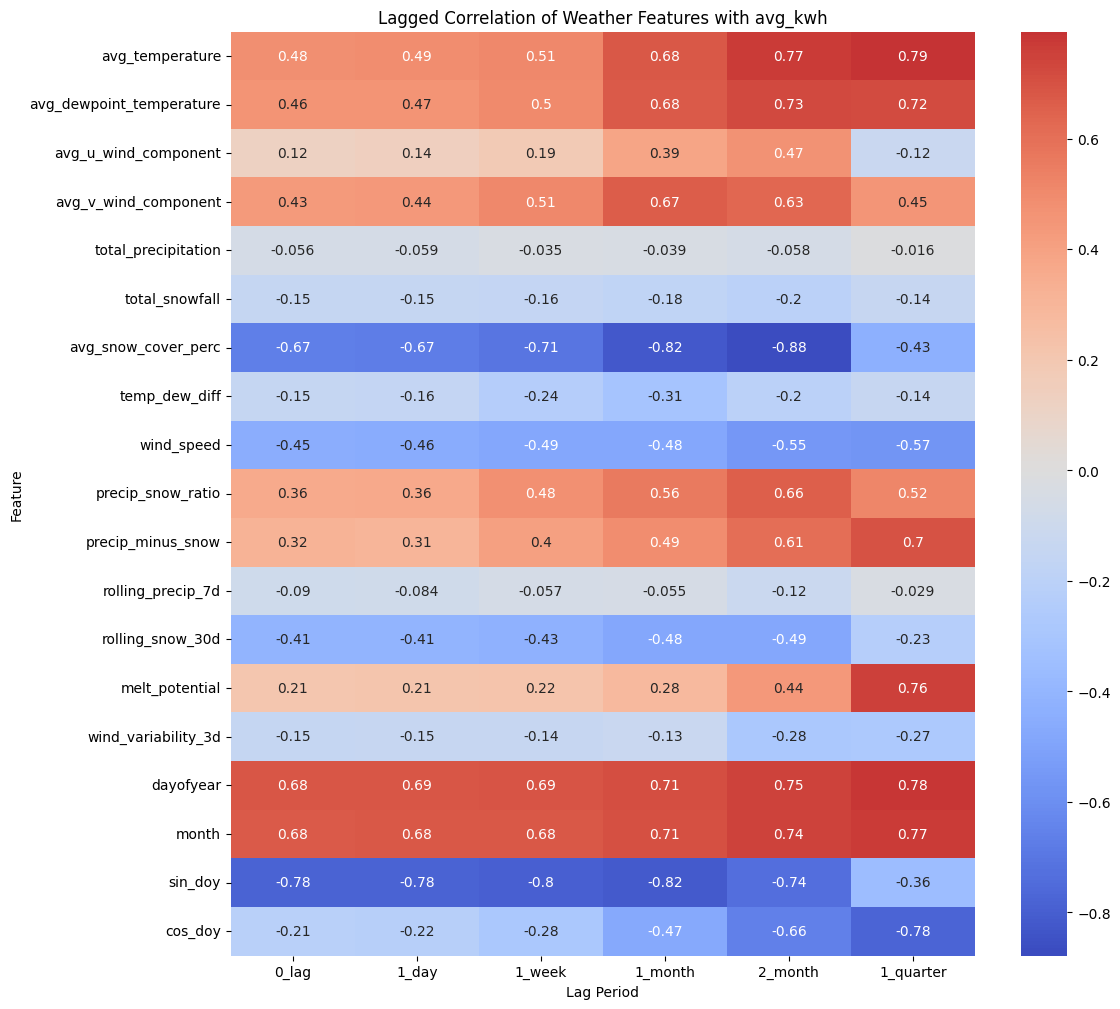

In [24]:
# Define lag periods (in days)
lags = {
    '0_lag': 0,
    '1_day': 1,
    '1_week': 7,
    '1_month': 30,
    '2_month': 60,
    '1_quarter': 90
}

# Store correlations for each lag
lagged_corrs = pd.DataFrame(index=features)

for label, lag_days in lags.items():
    df_lagged = all_data_df[all_data_df["date"] >= pd.Timestamp("2024-01-01")].copy()
    for feature in features:
        df_lagged[feature + '_lag'] = df_lagged[feature].shift(lag_days)
    df_lagged = df_lagged.dropna(subset=[f + '_lag' for f in features])
    
    corr_series = df_lagged[[f + '_lag' for f in features] + ['kwh']].corr()['kwh']
    # Drop 'kwh' itself and rename the index to remove '_lag'
    corr_series = corr_series.drop('kwh')
    corr_series.index = [i.replace('_lag', '') for i in corr_series.index]
    
    lagged_corrs[label] = corr_series

# Plot the results
plt.figure(figsize=(12, 12))
sns.heatmap(lagged_corrs, annot=True, cmap='coolwarm', center=0)
plt.title('Lagged Correlation of Weather Features with avg_kwh')
plt.ylabel('Feature')
plt.xlabel('Lag Period')
plt.show()


The following features at a lag of 30 days (~1month) seem to be good candidates
- Temperature/dewpoint temperature
- Wind speed
- Precip minus snow (rainfall)
- Precip to snow ratio

Now some of the features have strong correlations (like those involving snow) but looking at the signal plots, these could be spurrious relationships and don't make intuitive sense to use.

In [26]:
# The features are stored for future use
try:
    con.sql("""
        create table prepared.daily_features as
            select * from climate_df
    """)
except ddb.CatalogException as e:
    print(f"Table already exists: {e}")

In [27]:
con.close()